In [ ]:
# Pandarallelの準備
from pandarallel import pandarallel
pandarallel.initialize()

In [1]:
'''
差分内容
- RAWPFIの実装
'''

'\n差分内容\n- RAWPFIの実装\n'

In [2]:
# main module
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

# import pandas_profiling as pdp
import seaborn as sns

import lightgbm as lgb

from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

import datetime
import gc
import logging
import pickle
from pickle import load
import sys, os

# -------------------------------------独自モジュール-------------------------------------
sys.path.append('../src/') #モジュールが入っているディレクトリのパスを指定
import eda
import maprepro as mpre
import maprepro2 as mpre2

# import config
# from utils import setup_logger, ModelFactory
# -------------------------------------独自モジュール-------------------------------------

In [3]:
from modelvalid import PartialDependence

In [4]:
path = '../../input'
sample = pd.read_csv(f'{path}/sample_submission.csv')
store = pd.read_csv(f'{path}/store.csv')

test = pd.read_csv(f'{path}/test.csv',
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

train = pd.read_csv(f'{path}/train.csv',
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))


C:\Users\thyt\anaconda3\envs\rake4\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# テストのNaNレコードの処理
# testのOpenにNaNがあるがOpen=0とは限らないので、平日なら1,休日なら0に置換して
tmp1 = test.sort_values('Open')[:-11] # NaNじゃないやつ
tmp2 = test.sort_values('Open')[-11:] # NaNのやつ

tmp2['Open'] = np.where(tmp2['DayOfWeek'] < 5,1,0) # NaNをすべて置換完了
tmp3 = tmp2.loc[(tmp2['Open']==1)] # 上記のうち予測に使うやつ
tmp10000 = tmp2.loc[(tmp2['Open']!=1)] # 上記のうち予測に使わないが、最後にSales=0としてくっつけたいので更新されないであろう変数名で保管しておく

test = pd.concat([tmp1,tmp3],axis=0)

In [6]:
train = train.sort_values('Date')
test = test.sort_values('Date')

In [7]:
### Setting a variable to easily distinguish train (1) from submit (0) set
train['Set'] = 1
test['Set'] = 0
### Combine train and test set
frames = [train, test]
df = pd.concat(frames,axis=0)

In [8]:
'''dfに対する処理
- mk YMWD Dayofyear
- dateint
- Saleslog
- Saleslog - cliping
- 
'''
# 0と'0'が混ざっていたので置換
df['StateHoliday'] = df['StateHoliday'].replace({'0': 0})
df['StateHoliday']= df['StateHoliday'].astype('category').cat.codes


def mk_YMD_DOY(df):
    var_name = 'Date'
    df[var_name + 'Year'] = pd.Index(df[var_name]).year
    df[var_name + 'Month'] = pd.Index(df[var_name]).month
    df[var_name + 'Week'] = pd.Index(df[var_name]).week
    df[var_name + 'Day'] = pd.Index(df[var_name]).day
    df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear
    return df
df = mk_YMD_DOY(df)

df['DateInt'] = df['Date'].astype(np.int64)

C:\Users\thyt\AppData\Local\Temp/ipykernel_11960/1040694418.py:17: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df[var_name + 'Week'] = pd.Index(df[var_name]).week


In [9]:
# 目的変数の変換
df['Sales_log'] = np.log1p(df['Sales'])

In [10]:
# print(df.isnull().sum())
p01 = df.loc[(df['Set'] == 1)]['Sales_log'].quantile(0.01)
p09 = df.loc[(df['Set'] == 1)]['Sales_log'].quantile(0.9999)
df['Sales_log_clip'] = df['Sales_log'].clip(p01,p09)
# print('--'*80)
# print(df.isnull().sum())

In [11]:
'''
store処理
- PromoIntervalの処理
- dfと結合
'''
def processing_store(store):
    # --------------------------------- made promo 0,1,2,3 ---------------------------------

    s = store['PromoInterval'].str.split(',').apply(pd.Series,1)
    s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
    store = store.join(s)
    def monthToNum(date):
        return{
                'Jan' : 1,'Feb' : 2,'Mar' : 3,'Apr' : 4,'May' : 5,'Jun' : 6,'Jul' : 7,
                'Aug' : 8,'Sept' : 9, 'Oct' : 10,'Nov' : 11,'Dec' : 12
        }[date]

    store['PromoInterval0'] = store['PromoInterval0'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
    store['PromoInterval1'] = store['PromoInterval1'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
    store['PromoInterval2'] = store['PromoInterval2'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
    store['PromoInterval3'] = store['PromoInterval3'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

    # --------------------------------- category to int(rabel encoding) ---------------------------------
    # intなので決定木系でないと使えない処理
    store['StoreType'] = store['StoreType'].astype('category').cat.codes
    store['Assortment'] = store['Assortment'].astype('category').cat.codes
    
    return store

store = processing_store(store)

use = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval0',
       'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
notuse_store = ['PromoInterval']
df = pd.merge(df, store[use], how='left', on=['Store'])

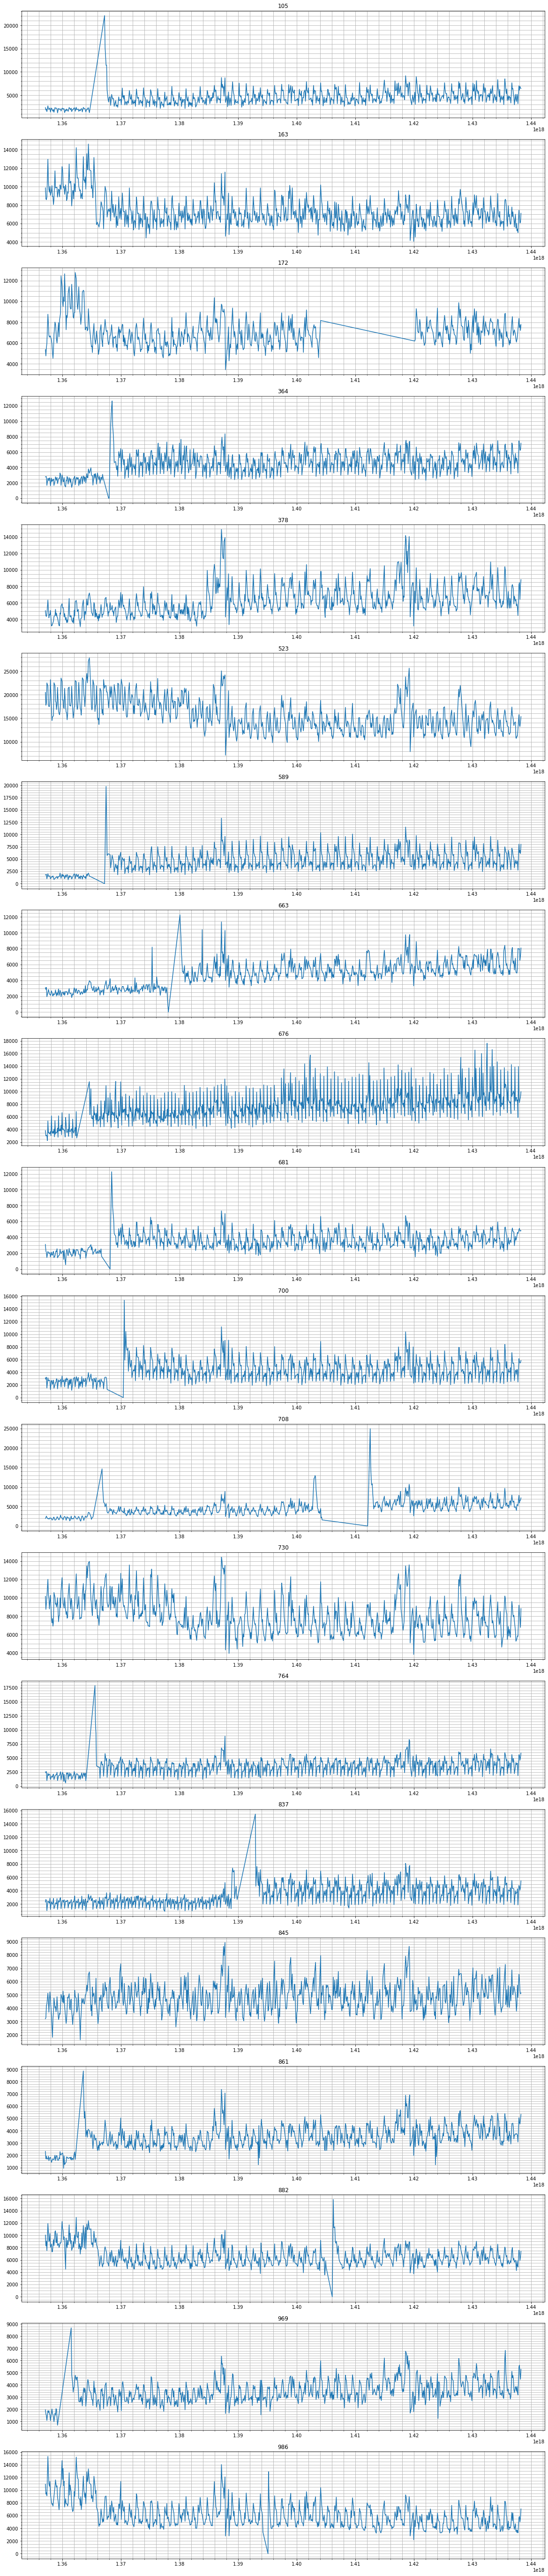

In [12]:
# tmp = df.groupby(['Store','Y_M']).agg({'Sales':'mean'}).reset_index()

list_stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]
# list_stores_to_check = list(range(1,30))

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # 月平均
#     X1 = tmp.loc[(tmp['Store'] == stor)]
#     y1 = tmp.loc[(tmp['Store'] == stor)]['Sales']

#     plt.subplot(len(list_stores_to_check),1,j)
#     plt.plot(X1['Y-M'], y1, '-')
#     plt.minorticks_on(); plt.grid(True, which='both') # whichがbothなので主目盛り副目盛り両方グリッド線を描画
#     plt.title(i)
    
    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']
    
    plt.subplot(len(list_stores_to_check),1,j)
#     plt.plot(X1['Date'], y1, '-')
    plt.plot(X1['DateInt'], y1, '-')
    
    plt.minorticks_on(); plt.grid(True, which='both') # whichがbothなので主目盛り副目盛り両方グリッド線を描画
    plt.title(i)
    j += 1

In [13]:
store_dates_to_remove = {   105:1.368e18, 163:1.368e18,
                            172:1.366e18, 364:1.37e18,
                            378:1.39e18, 523:1.39e18,
                            589:1.37e18, 663:1.39e18,
                            676:1.366e18, 681:1.37e18,
                            700:1.373e18, 708:1.368e18,
                            709:1.423e18, 730:1.39e18,
                            764:1.368e18, 837:1.396e18,
                            845:1.368e18, 861:1.368e18,
                            882:1.368e18, 969:1.366e18,
                            986:1.368e18, 192:1.421e18,
                            263:1.421e18, 500:1.421e18,
                            797:1.421e18, 815:1.421e18,
                            825:1.421e18}

# for key,value in store_dates_to_remove.iteritems():
for key,value in store_dates_to_remove.items():
    df.loc[(df['Store'] == key) & (df['DateInt'] < value), 'Delete'] = True

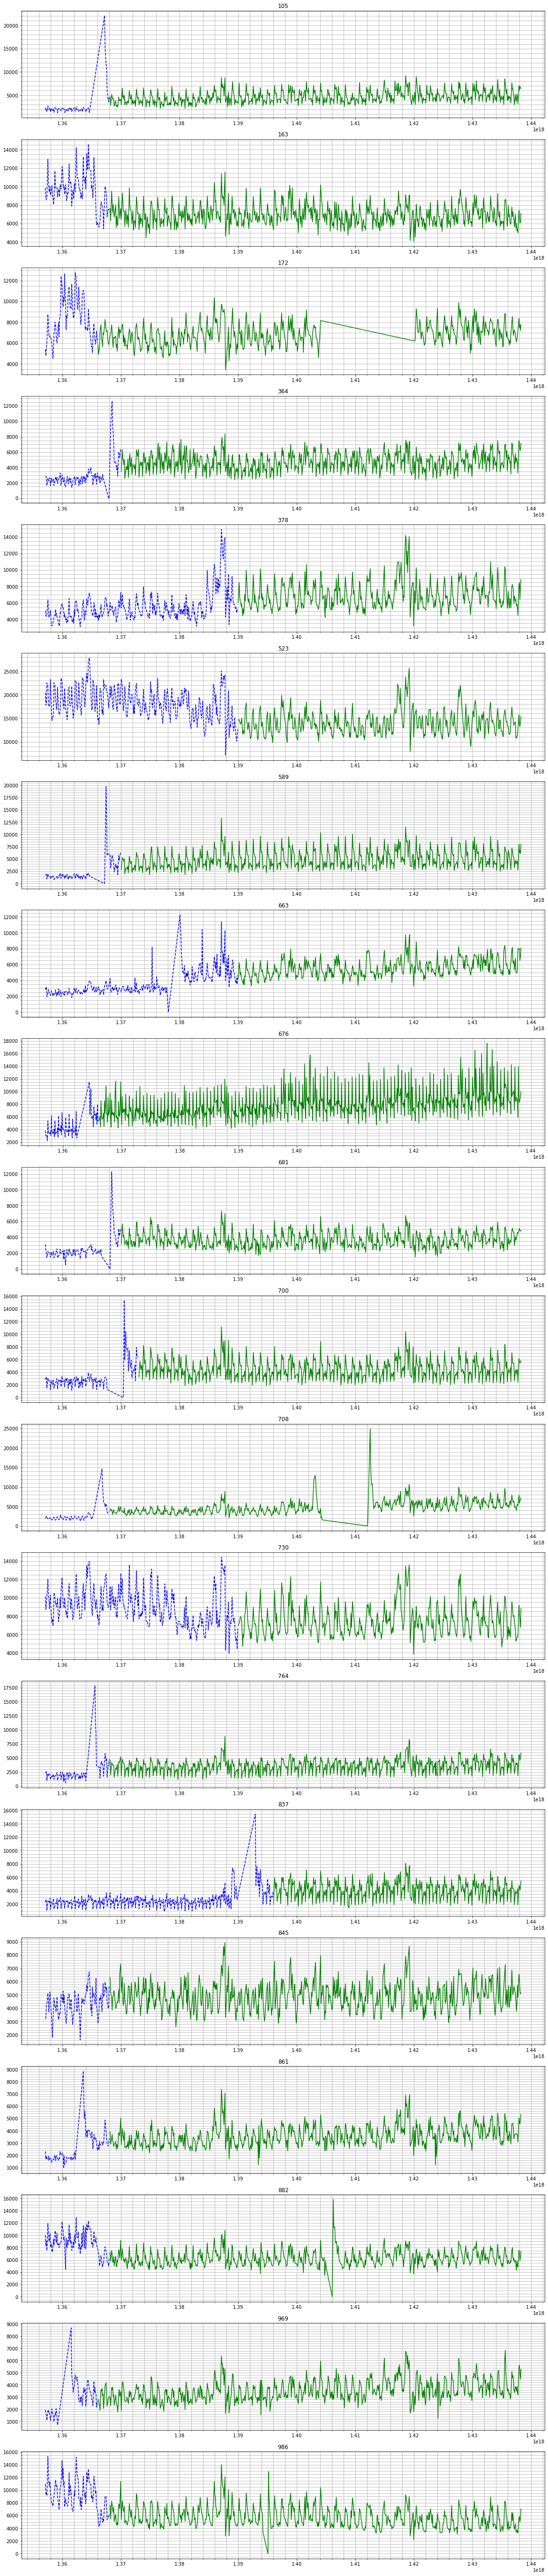

In [14]:
list_stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] == True)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] == True)]['Sales']
    
    X2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] != True)]
    y2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] != True)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, 'b--') # 'r--o','r-o','r-'
    plt.plot(X2['DateInt'], y2, '-',color='g')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

In [15]:
# df.loc[(df['Set']==0) & (df['Delete'] == True)]
# df.loc[(df['Set']==0)].Delete.unique()

print(df.shape)
df = df.loc[df['Delete'] != True]
print(df.shape)
df = df.loc[(df['Open'] == 1)]
print(df.shape)

(1058294, 32)
(1050230, 32)
(873061, 32)


In [16]:
def mk_series_cv(df):
    df = df.sort_values('Date')
    # 時系列データであり、時間に沿って変数periodを設定したとする
    tmptr = df.loc[(df['Set'] == 1)]
    tmptr['period'] = np.arange(0, len(tmptr))// (len(tmptr)//4)
    tmptr['period'] = np.clip(tmptr['period'], 0, 3)

    tmpte = df.loc[(df['Set'] == 0)]
    tmpte['period'] = 4
    df = pd.concat([tmptr,tmpte],axis=0)
    return df

df = mk_series_cv(df)

C:\Users\thyt\AppData\Local\Temp/ipykernel_11960/3903009145.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmptr['period'] = np.arange(0, len(tmptr))// (len(tmptr)//4)
C:\Users\thyt\AppData\Local\Temp/ipykernel_11960/3903009145.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmptr['period'] = np.clip(tmptr['period'], 0, 3)
C:\Users\thyt\AppData\Local\Temp/ipykernel_11960/3903009145.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [17]:
tmp = ['Promo2SinceWeek','Promo2SinceYear','PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Customers','CompetitionDistance']
eda.miss_check(df[tmp])
# df.fillna(-1)

Your selected dataframe has 10 columns.
There are 10 columns that have missing values.


Missing Values  % of Total Values
Promo2SinceWeek                    435595               49.9
Promo2SinceYear                    435595               49.9
PromoInterval0                     435595               49.9
PromoInterval1                     435595               49.9
PromoInterval2                     435595               49.9
PromoInterval3                     435595               49.9
CompetitionOpenSinceMonth          280819               32.2
CompetitionOpenSinceYear           280819               32.2
Customers                           35101                4.0
CompetitionDistance                  2259                0.3

In [18]:
# train_x['StateHoliday'] = store['Assortment'].astype('category').cat.codes


In [19]:
df['StateHoliday'] = df.StateHoliday.astype('category')    
categorical_features = ['StateHoliday']

# alltmp = sorted(df.columns)
testid = ['Id']
target = ['Sales_log_clip']
# target = ['Sales','Sales_log']

notuse = ['Id','Date','Delete','Date','Y_M','Set','Sales','DateInt',]
use = ['Store','DayOfWeek','Open','Promo',
'StateHoliday','SchoolHoliday','DateYear','DateMonth','DateWeek','DateDay','DateDayOfYear',
'StoreType','Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
'Promo2','period']

train_x = df.loc[(df['Set'] == 1)][use]
train_y = df.loc[(df['Set'] == 1)][target]
test = df.loc[(df['Set'] == 0)]
test = test.sort_values('Id').reset_index(drop=True)
test_x = test[use]
testid = test[testid]
testid = testid.Id.astype(np.int32)

In [20]:
import warnings
warnings.simplefilter('ignore')
train_x = eda.reduce_mem_usage(train_x)

start size(BEFORE): 104.69 Mb
Mem. usage decreased to 27.97 Mb (AFTER:73.3% reduction)


In [21]:
# --------------------------------------------------
import maprepro2 as mpre2
NOW,TMP_DIR = mpre2.mk_dir()
gc.collect()
# --------------------------------------------------

va_period_list = [1, 2, 3]
for va_period in va_period_list:
    print('i ================================================================== ',va_period)
    is_tr = train_x['period'] < va_period
    is_va = train_x['period'] == va_period
    tr_x, va_x = train_x[is_tr], train_x[is_va]
    tr_y, va_y = train_y[is_tr], train_y[is_va]
    
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y)

    # ハイパーパラメータの設定
    params = {'objective': 'regression',
                'seed': 71,
                'verbose': 1,
                'metrics': 'rmse',
                'force_col_wise':'true' # メモリが足りないから
                }
    num_round = 100

    # 学習の実行
    categorical_features = categorical_features
    model = lgb.train(params, lgb_train, num_boost_round=num_round,
                    categorical_feature=categorical_features,
                    valid_names=['train', 'valid'], valid_sets=[lgb_train, lgb_eval],
                    )


    filename = f'{TMP_DIR}/trained_model{va_period}.pkl'
    pickle.dump(model, open(filename, 'wb'))

    # バリデーションデータでのスコアの確認
    va_pred = model.predict(va_x); va_pred = va_pred.reshape(-1, 1)

    # Open=0の日はすべてSalesが0で、0以外を予測することはありえないので0で更新(モデルは自然数を予測しているみたいだが、
    # Open=0ならSales=0をモデルに教えられていないということ)
#     tmp = va_x['Open'] == 0
#     va_pred[tmp]=0
    va_pred=va_pred+1; va_y=va_y+1

    # --------------------------------------------------
    # score = mean_squared_error(va_y, va_pred)
    RMSPE = np.sqrt(np.mean(((  (va_y-va_pred)/va_y)**2) )).values
    RMSPE = RMSPE.astype(float)[0] # printのために単一の数値にしたかった
    # score = log_loss(va_y, va_pred)
    print('RMSPE RMSPE RMSPE RMSPE RMSPE RMSPE: {:.4f}'.format(RMSPE))
    # --------------------------------------------------

#     del model # 学習済みモデルを削除


i ==================================================================  1
[LightGBM] [Info] Total Bins 880
[LightGBM] [Info] Number of data points in the train set: 209490, number of used features: 15
[LightGBM] [Info] Start training from score 8.723874
[1]	train's rmse: 0.414627	valid's rmse: 0.42129
[2]	train's rmse: 0.404443	valid's rmse: 0.411984
[3]	train's rmse: 0.395461	valid's rmse: 0.403699
[4]	train's rmse: 0.388111	valid's rmse: 0.397011
[5]	train's rmse: 0.381724	valid's rmse: 0.39119
[6]	train's rmse: 0.376278	valid's rmse: 0.38621
[7]	train's rmse: 0.371688	valid's rmse: 0.382349
[8]	train's rmse: 0.367439	valid's rmse: 0.378316
[9]	train's rmse: 0.363697	valid's rmse: 0.37509
[10]	train's rmse: 0.360255	valid's rmse: 0.371963
[11]	train's rmse: 0.357167	valid's rmse: 0.369148
[12]	train's rmse: 0.354772	valid's rmse: 0.367481
[13]	train's rmse: 0.352212	valid's rmse: 0.365093
[14]	train's rmse: 0.349619	valid's rmse: 0.362625
[15]	train's rmse: 0.347282	valid's rmse: 0.360

In [22]:
var_names = list(train_x.columns)

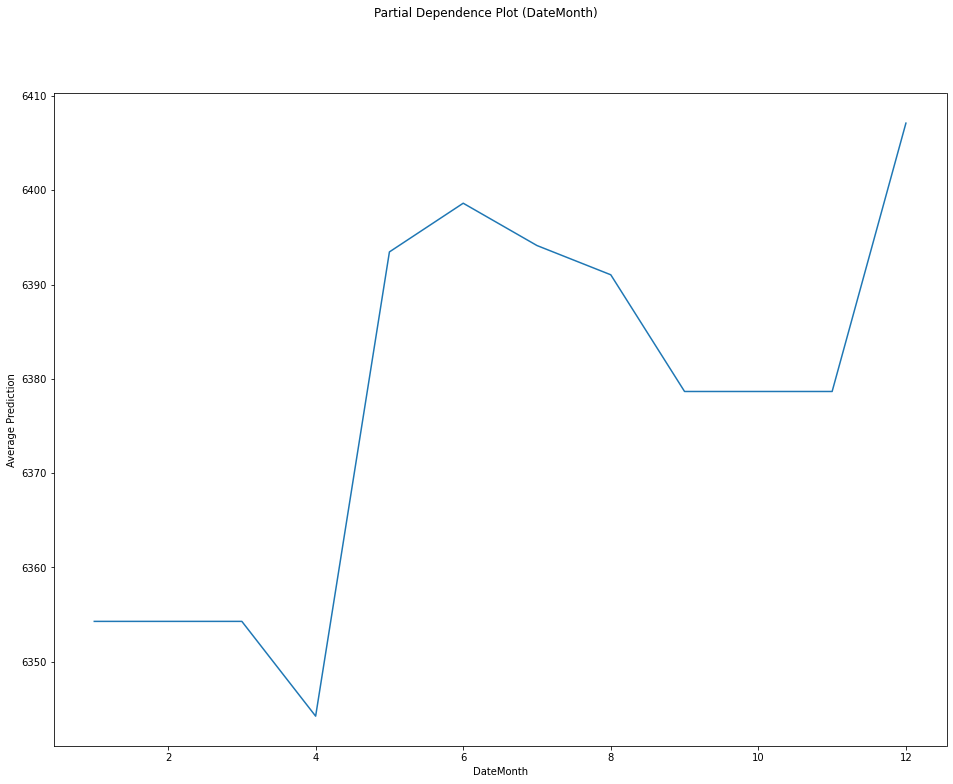

In [25]:
# model = modeldict[3]
# PDのインスタンスを作成
# pandasとかぶるので、変数名はpdではなくpdp(partial dependence plot)とした
pdp = PartialDependence(model, train_x.values, list(train_x.columns))

# # X1に対するPDを計算
pdp.partial_dependence("DateMonth", n_grid=12)
# expm1かけて戻してあげる
pdp.df_partial_dependence['avg_pred'] = np.expm1(pdp.df_partial_dependence['avg_pred'])

# PDを可視化
pdp.plot(figsize=(16,12))

In [ ]:
from sklearn.inspection import permutation_importance

# PFIを計算
pfi = permutation_importance(
    estimator=model,
    X=va_x,
    y=va_y,
    scoring="neg_root_mean_squared_error",  # 評価指標はRMSEを指定
    n_repeats=5,  # シャッフルの回数
    n_jobs=-1,
    random_state=42,
)

pfi

In [ ]:
# 自作モジュール
sys.path.append('./src/mli/') #モジュールが入っているディレクトリのパスを指定
# from mli.interpret import PermutationFeatureImportance

# PFIを計算して可視化
# PFIのインスタンスの作成

# pfi = PermutationFeatureImportance(model, va_x, va_y, var_names)
pfi = PermutationFeatureImportance(model, va_x, va_y, var_names)

# PFIを計算
pfi.permutation_feature_importance()

# PFIを可視化
# pfi.plot(importance_type="difference")

In [64]:
modeldict = mpre2.load_models(TMP_DIR)

load開始
load終わりました


In [ ]:
pred_dict = mpre2.mk_pred_dict(modeldict,test_x)

予測リストが入った辞書作成開始
予測リストが入った辞書作成終了


In [ ]:
# pred_wei_average = mpre2.wei_average(pred_dict,len(test_x))
# 重み付き平均がバグってたので算術平均で、変数名はそのままなので注意
pred_wei_average = (sum(pred_dict.values())/3)

In [ ]:
pred_wei_average = np.expm1(pred_wei_average)
subpred = pd.DataFrame(pred_wei_average)
testid = testid.reset_index(drop=True)

sub = pd.concat([testid,subpred],axis=1)
sub.columns = ['Id','Sales']

In [ ]:
tmptest = pd.read_csv(f'{path}/test.csv')
tmp9999 = tmptest.loc[(tmptest['Open']==0)]
'''
tmp9999 # Open=0のやつ
tmp10000 # Open=NaNのやつで、休日っぽいから冒頭でOpen=0に置換して保存しておいたやつ
'''
tmptest = pd.concat([tmp9999,tmp10000],axis=0)
tmptest = tmptest[['Id']]
tmptest['Sales']=0
tmptest
sub2 = pd.concat([tmptest,sub],axis=0)

In [2]:
mpre2.mk_output(df=sub2,NOW=NOW,PRACTICE=False)

NameError: name 'mpre2' is not defined

In [3]:
# fig, ax = plt.subplots()などの後にax.plotなどを使う流儀です。figやaxはこの記事で説明するArtistと呼ばれるオブジェクトの一種です。一番シンプルな例はこんな感じです。
x = range(0,10)
y = list(range(100,110))

fig, ax = plt.subplots()
ax.plot(x,y)

# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# ax.plot(x, y)

NameError: name 'plt' is not defined

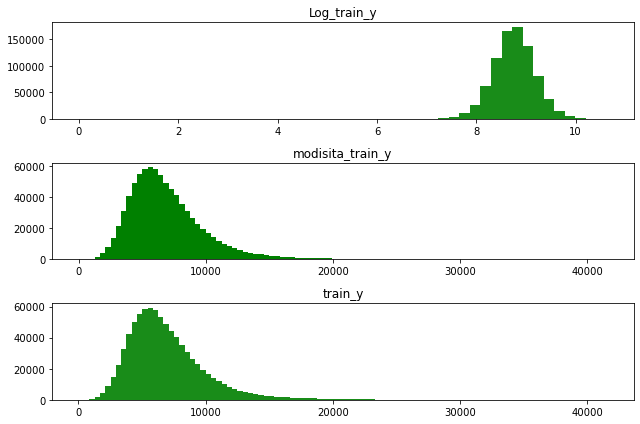

In [91]:
import matplotlib.pyplot as plt
fig1 = plt.figure(1,figsize=(9,6))

#1つ目のウィンドウ 1つ目のグラフ
ax1 = fig1.add_subplot(311)
# ax1.hist(np.expm1(train_y),bins=50, histtype='bar',color='g',alpha=0.9)
ax1.hist(df['Sales_log'],bins=50, histtype='bar',color='g',alpha=0.9)
ax1.set_title('Log_train_y')

#1つ目のウィンドウ 2つ目のグラフ
ax2 = fig1.add_subplot(312)
ax2.hist(np.expm1(df['Sales_log']),bins=100, histtype='bar',color='g')
# ax2.set_ylim( (-2,2) )
ax2.set_title('modisita_train_y')

#1つ目のウィンドウ 3つ目のグラフ
ax3 = fig1.add_subplot(313)
ax3.hist(train['Sales'][train['Sales']>0],bins=100, histtype='bar',color='g',alpha=0.9)
# ax2.set_ylim( (-2,2) )
ax3.set_title('train_y')

fig1.tight_layout()  # グラフの文字がかぶらないようにする


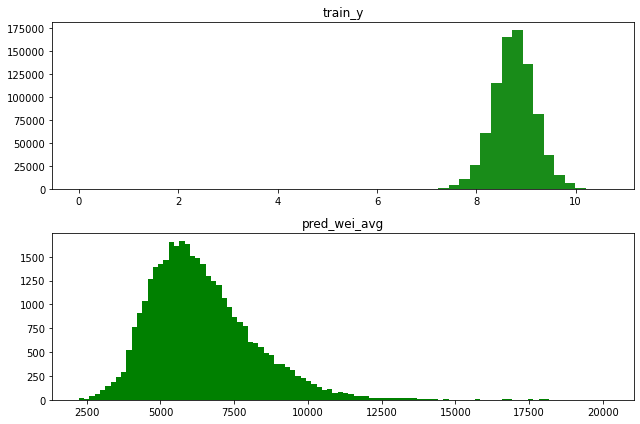

In [92]:
import matplotlib.pyplot as plt
fig1 = plt.figure(1,figsize=(9,6))
#1つ目のウィンドウ 1つ目のグラフ
ax1 = fig1.add_subplot(211)
# ax1.hist(np.expm1(train_y),bins=50, histtype='bar',color='g',alpha=0.9)
ax1.hist(train_y,bins=50, histtype='bar',color='g',alpha=0.9)
ax1.set_title('train_y')

#1つ目のウィンドウ 2つ目のグラフ
ax2 = fig1.add_subplot(212)
# ax2.hist(np.expm1(pred_wei_average),bins=100, histtype='bar',color='g')
ax2.hist(pred_wei_average,bins=100, histtype='bar',color='g')
# ax2.set_ylim( (-2,2) )
ax2.set_title('pred_wei_avg')

fig1.tight_layout()  # グラフの文字がかぶらないようにする


In [93]:
df['Sales_log']import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(20, 6))
# plt.hist(sub2.Sales,bins=50, histtype='bar',color='g',alpha=0.9)
# plt.hist(train.Sales,bins=50, histtype='bar',color='g',alpha=0.3)
# # sub2.Sales.plot.hist(ax=ax,figsize=(20, 6),bins=50, histtype='bar',color='g')
# # ax = fig.add_subplot(2, 1, 2)
# np.log1p(train.Sales).plot.hist(ax=ax,figsize=(20, 6),bins=100, histtype='bar',color='g')
# plt.show()

fig1 = plt.figure(1,figsize=(9,6))
#1つ目のウィンドウ 1つ目のグラフ
ax1 = fig1.add_subplot(211)
ax1.hist(sub2.Sales,bins=50, histtype='bar',color='g',alpha=0.9)
ax1.grid(True)
# # ax1.set_ylim( (-2,2) )
ax1.set_xlabel('Pred')
ax1.set_ylabel('Freq')
# ax1.set_title('sin function')

#1つ目のウィンドウ 2つ目のグラフ
ax2 = fig1.add_subplot(212)
ax2.hist(train.Sales,bins=100, histtype='bar',color='g')
ax2.grid(True)
# ax2.set_ylim( (-2,2) )
ax2.set_xlabel('train')
ax2.set_ylabel('Freq')
# ax2.set_title('cos function')

SyntaxError: invalid syntax (<ipython-input-93-5b65ee70b936>, line 1)

In [ ]:
fig1 = plt.figure(1,figsize=(9,6))
t = np.linspace(-1,1,1000)
#1つ目のウィンドウ 1つ目のグラフ
ax1 = fig1.add_subplot(211)
ax1.plot(t, np.sin(2*np.pi*t))
ax1.grid(True)
ax1.set_ylim( (-2,2) )
ax1.set_xlabel('t')
ax1.set_ylabel('f (t)')
ax1.set_title('sin function')

################################
#1つ目のウィンドウ 2つ目のグラフ
################################
ax2 = fig1.add_subplot(212)
ax2.plot(t, np.cos(2*np.pi*t))
ax2.grid(True)
ax2.set_ylim( (-2,2) )
ax2.set_xlabel('t')
ax2.set_ylabel('f (t)')
ax2.set_title('cos function')